# Plotting

Notebook dedicated to plotting the results of the explainer calculations

In [1]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)




In [2]:
# Configurations

Settings=["Base", "Random", "Energy","Gamma"]
Model_types=["True", "Complex", "Simple"]
Param_array = [{'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2},
                  {'alpha' : 1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
                  {'alpha' : -1.0, 'beta' : -1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 0.1},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2}]


i = 0
k = 1

plot_features = [r"$x_0$", r"$v_0$", r"$t$"]
plot_labels = [r"$x_t$", r"$v_t$"]

feature_setting = Settings[i]
params = Param_array[k]

plot_features.append(feature_setting)
results_folder = "Array_Submission_8/"
save = True
save_suffix = "_setting_"+str(i)+"_param_"+str(k)


if feature_setting == "Base":
    from Array_Submission_8.BaseDuffing import Duffing
elif feature_setting == "Random":
    from Array_Submission_8.RandomDuffing import Duffing
elif feature_setting == "Energy":
    from Array_Submission_8.EnergyDuffing import Duffing
elif feature_setting == "Gamma":
    from Array_Submission_8.GammaDuffing import Duffing


In [3]:
# load dataset
duffing = Duffing(parameters = params)
eom = duffing.eom
features = duffing.features
labels = duffing.labels

# generate some data to train the scaler

end_time = 20 #100
duffing.generate(200, samples = 50, end_time = end_time)
duffing.scale_features()

Generating Data…: 100%|█████████████████| 200/200 [00:01<00:00, 146.25it/s]


In [4]:
big_df = pd.DataFrame()
models = {}
histories = {}
for j in Model_types:
    print(j)
    suffix = feature_setting + "_" + j + "_" + duffing.suffix
    print(suffix)
    temp_df = pd.read_csv(results_folder+"Results/explainer_dataframe_"+suffix+".csv")
    temp_df.insert(0, "Model", [j for i in range(temp_df.shape[0])])
    big_df = big_df.append(temp_df)
    if j == "True":
        models[j] = duffing
        histories[j] = None
    elif j != "True":
        models[j] = tf.keras.models.load_model(results_folder+"Models/Model"+suffix)
        histories[j] = pickle.load(open(results_folder+'Models/TrainingHistory/'+suffix, "rb"))  
        
X = pd.DataFrame(duffing.scaler.inverse_transform(big_df[features]), columns = features)
y = pd.DataFrame(duffing.predict(big_df[features]), columns = labels)

True
Base_True__-1.0_1.0_0.37_1.0_1.2
Complex
Base_Complex__-1.0_1.0_0.37_1.0_1.2
Simple
Base_Simple__-1.0_1.0_0.37_1.0_1.2


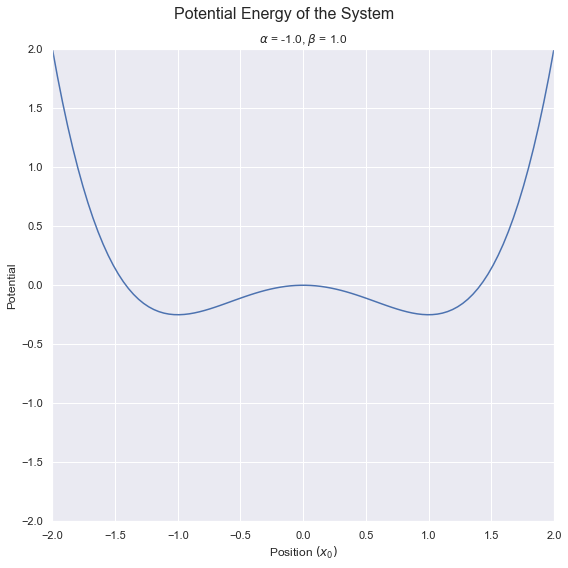

In [5]:
f, axs = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw=dict(width_ratios=[4]))

x_potential = np.linspace(-2,2,100)
v_potential = 0
y_potential = (0.5*v_potential**2 + 0.5*params['alpha']*x_potential**2 +0.25*params['beta']*x_potential**4)

sns.lineplot(x = x_potential, y=y_potential,ax=axs)

axs.set_xlabel(r'Position $(x_0)$')
axs.set_ylabel('Potential')
axs.set_title(r"$\alpha$ = "+str(params['alpha']) + r", $\beta$ = "+str(params['beta']))
axs.set(xlim=(-2, 2), ylim=(-2, 2))
    
f.suptitle("Potential Energy of the System", fontsize = 16)
f.tight_layout()

if save == True:
    f.savefig("Images/Potential/"+save_suffix+".svg", dpi='figure')

In [6]:
choice = duffing.X_df[features].iloc[np.sort(np.random.choice(duffing.X_df[features].shape[0], 500, replace =False))]
y_pred = {"True" : pd.DataFrame(duffing.predict(big_df[features]), columns = duffing.labels)}
model_plot = {"True" : pd.DataFrame(duffing.predict(choice), columns = duffing.labels)}
plot_t = pd.DataFrame(duffing.scaler.inverse_transform(choice), columns = features)['t']

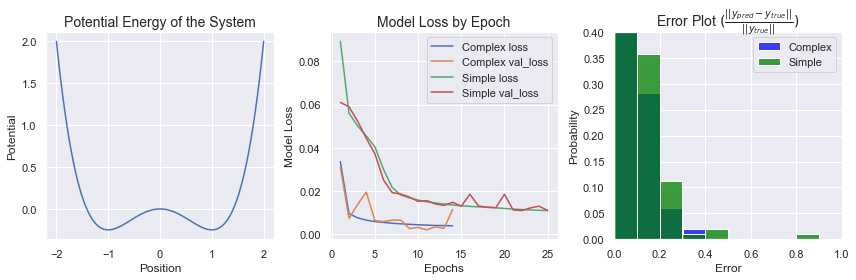

In [7]:
colours = {"Complex" : "blue", "Simple" : "green"}
f, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4,4,4]))

x_potential = np.linspace(-2,2,100)

v_potential = 0
y_potential = (0.5*v_potential**2 + 0.5*params['alpha']*x_potential**2 +0.25*params['beta']*x_potential**4)



sns.lineplot(x = x_potential, y=y_potential,ax=axs[0])

axs[0].set_xlabel('Position')
axs[0].set_ylabel('Potential')
axs[0].set_title("Potential Energy of the System", fontsize = 14)


for model_ in ["Complex", "Simple"]:
    suffix = feature_setting + "_" + model_ + "_" + duffing.suffix
    model = models[model_]
    history = histories[model_]
    
    y_pred[model_] = pd.DataFrame(model.predict(big_df[features]), columns = duffing.labels)
    model_plot[model_] = pd.DataFrame(model.predict(choice), columns = duffing.labels)

    # evaluate NN performance

    """
    Evaluate Model
    """

    # evaluate the fitting validation and training losses
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    ## Make Prdictions on the Test Dataset
    #y_pred = pd.DataFrame(model.predict(big_df[features]), columns=['xt','vt'])

    pred_norm = np.linalg.norm(y_pred[model_][['xt','vt']].values,axis=1)
    true_norm = np.linalg.norm(y_pred["True"][['xt','vt']].values,axis=1)
    hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
    hist_data = pd.DataFrame(hist_data, columns=['norm'])

    def Remove_Outlier_Indices(df):
        Q1 = df.quantile(0.00)
        Q3 = df.quantile(0.95)
        IQR = Q3 - Q1
        trueList = ~((df > (Q3 + 1.5 * IQR)))
        #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
        return trueList

    indices = Remove_Outlier_Indices(hist_data)
    hist_data = hist_data[indices]
    # Model Loss and Error

    sns.lineplot(data = history, x = epochs, y='loss',ax=axs[1], label=model_+' loss')
    sns.lineplot(data = history, x = epochs, y='val_loss',ax=axs[1], label=model_ +' val_loss')

    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Model Loss')
    axs[1].set_title("Model Loss by Epoch", fontsize = 14)
    axs[1].legend()


    # Error Plot for ML Predictions
    sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.1, ax=axs[2], label = model_, color = colours[model_])

    axs[2].set(xlim=(0, 1), ylim=(0, 0.4))
    axs[2].set_xlabel('Error')
    axs[2].set_ylabel('Probability')
    axs[2].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$", fontsize = 14)
    axs[2].legend()

f.tight_layout()

if save == True:
    f.savefig("Images/Performance/"+save_suffix+".svg", dpi='figure')


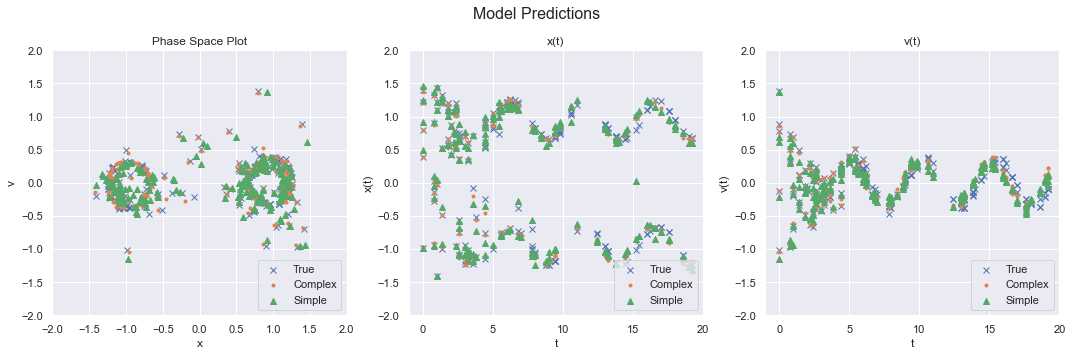

In [18]:
# Predictions Plot ML Model
f, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw=dict(width_ratios=[4,4,4]))
markers = {"True" : 'x', "Complex" : '.', "Simple" : '^'}
for model_ in Model_types:
    # phase space plot
    sns.scatterplot(data = model_plot[model_].iloc[:200,:], x = 'xt', y='vt',ax=axs[0], label=model_,
                marker=markers[model_], linewidth = 1, edgecolor = None)
    # xt against time
    sns.scatterplot(data = model_plot[model_].iloc[:200,:], x = plot_t[:200], y='xt',ax=axs[1],label=model_,
                marker=markers[model_], linewidth = 1, edgecolor = None)
    # vt against time
    sns.scatterplot(data = model_plot[model_].iloc[:200,:], x = plot_t, y='vt',ax=axs[2],label=model_,
                marker=markers[model_], linewidth = 1, edgecolor = None)
    
axs[0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[0].set_xlabel('x')
axs[0].set_ylabel('v')
axs[0].set_title("Phase Space Plot")
axs[0].legend(loc = 4)

axs[1].set(xlim=(-1, 20), ylim=(-2, 2))
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')
axs[1].set_title("x(t)")
axs[1].legend(loc = 4)

axs[2].set(xlim=(-1, 20), ylim=(-2, 2))
axs[2].set_xlabel('t')
axs[2].set_ylabel('v(t)')
axs[2].set_title("v(t)")
axs[2].legend(loc = 4)

f.suptitle("Model Predictions", fontsize = 16)
f.tight_layout()

if save == True:
    f.savefig("Images/Predictions/"+save_suffix+".svg", dpi='figure')

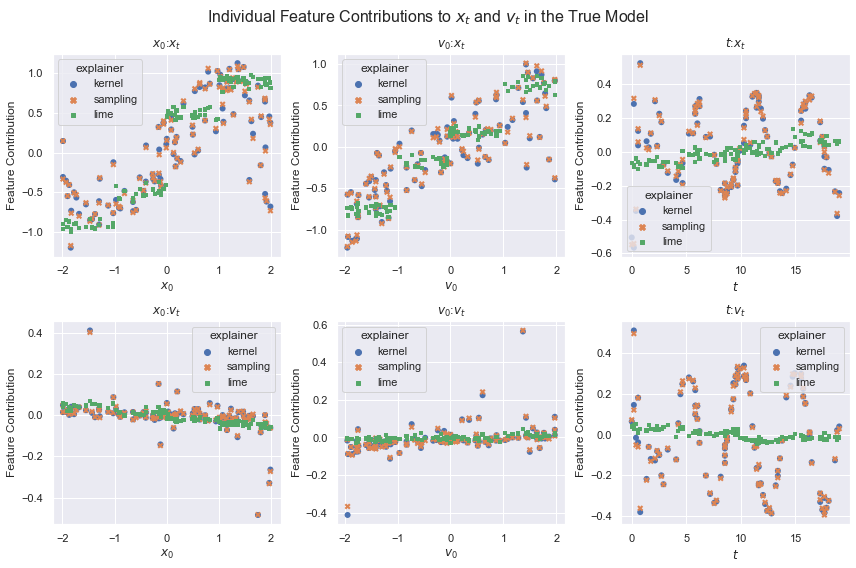

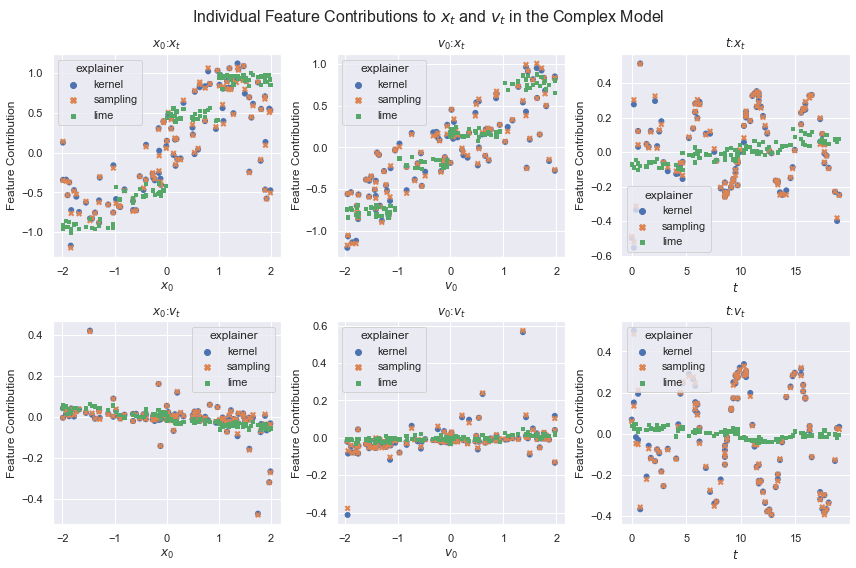

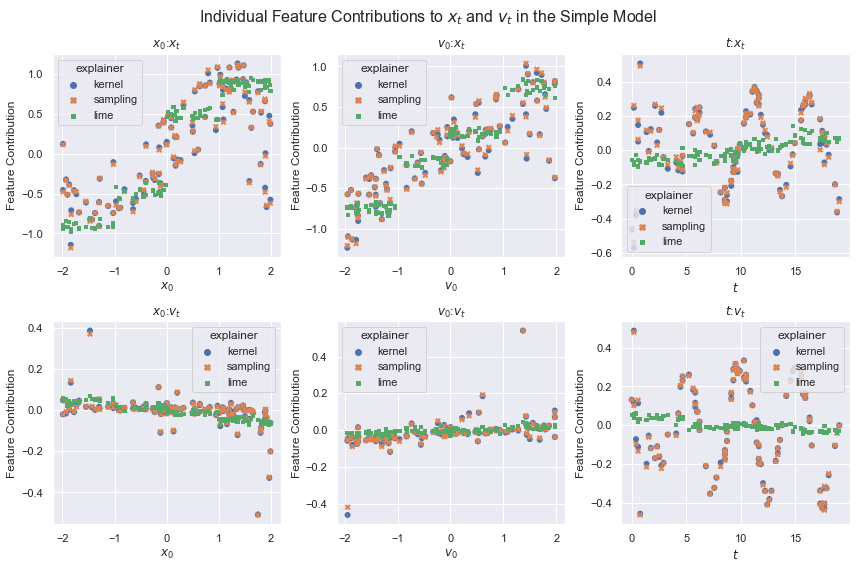

In [17]:
for models_ in big_df['Model'].unique():
    plotting_df = big_df.where(big_df["explainer"].isin(["sampling", "kernel", "lime"])).where(big_df["Model"]==models_).dropna()
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none")
            axs[j,i].set_title(plot_features[i]+":"+plot_labels[j])
            axs[j,i].set_xlabel(plot_features[i])
            axs[j,i].set_ylabel('Feature Contribution')
    f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$ in the " + models_ + " Model", fontsize = 16)

    f.tight_layout()
    if save == True:
        f.savefig("Images/Individual/"+models_+"_"+save_suffix+".svg", dpi='figure')

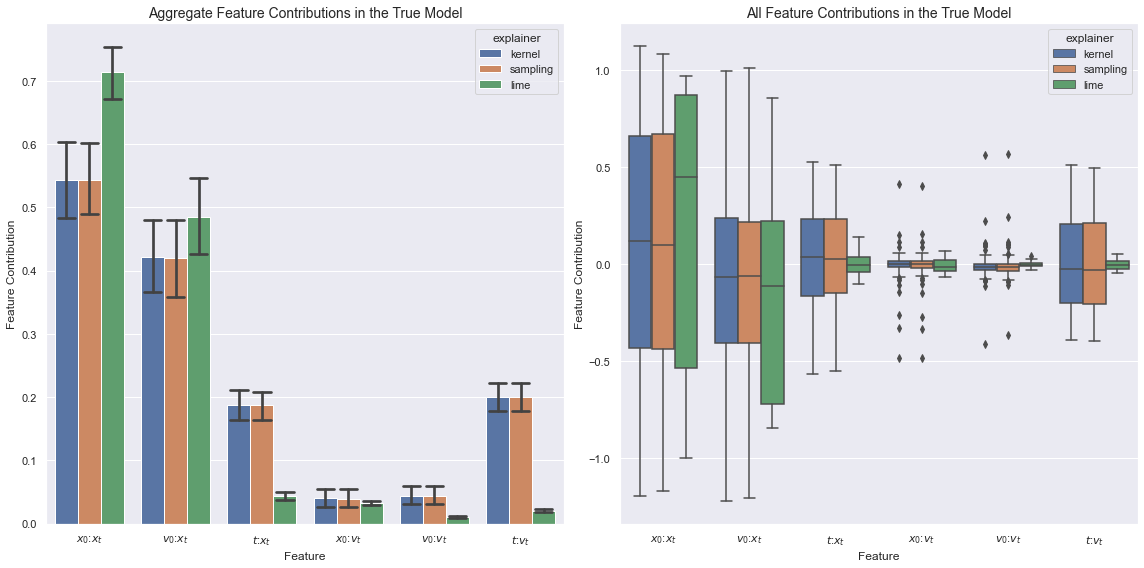

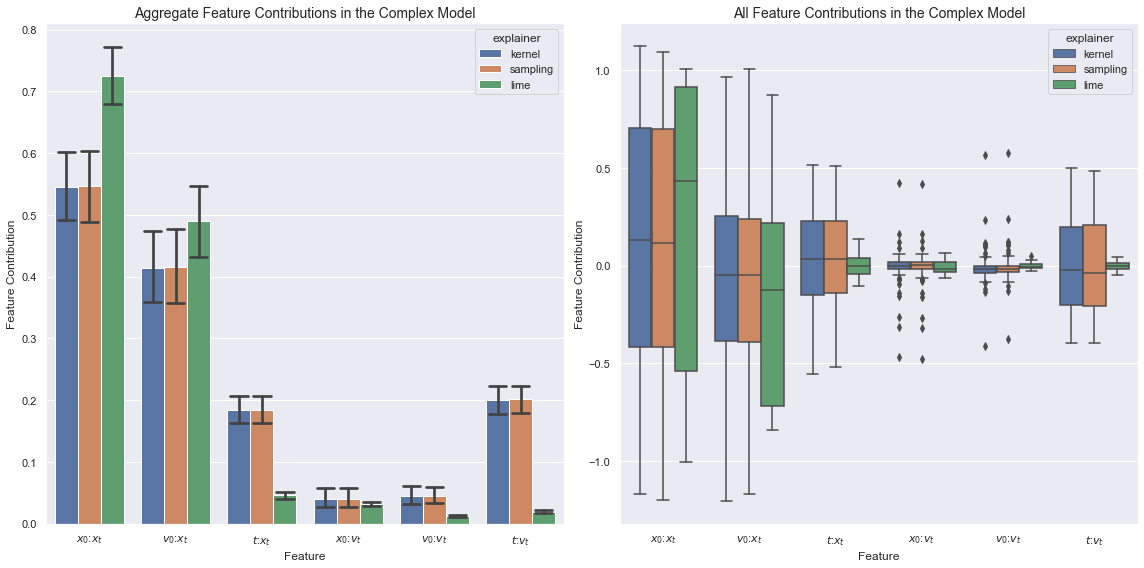

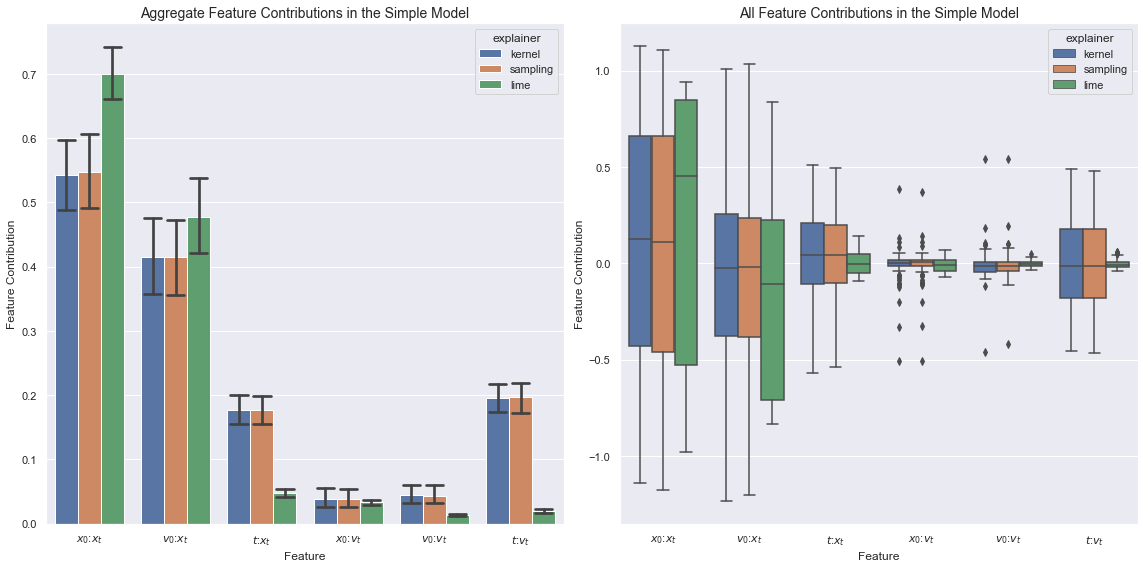

In [12]:
# Convert Data to Long Form to enable plotting with sns barplot
for model_ in Model_types:
    
    plot_cols = [label_+"_"+feat_ for label_ in duffing.labels for feat_ in duffing.features]
    plot_cols.append("explainer")
    model_df = big_df.where(big_df['Model'] == model_).dropna()
    agg_df = model_df[plot_cols].copy().set_index('explainer')
    temp_df = pd.DataFrame()
    agg_df_2 = pd.DataFrame()
    for j, col in enumerate(agg_df.columns[:8]):
        for expl in agg_df.index.unique():
            temp_df['value'] = agg_df.loc[expl][col].values
            temp_df['feature'] = col
            temp_df['explainer'] = expl
            agg_df_2 = agg_df_2.append(temp_df)

    agg_df_3 = agg_df_2.where(agg_df_2["explainer"].isin(["kernel", "sampling", "lime"])).dropna()
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            agg_df_3 = agg_df_3.replace(label_+"_"+feat_, plot_features[i] +":" +plot_labels[j])
            
    # aggregated feature importance

    # Aggregated

    f, axs = plt.subplots(1, 2, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4]))


    sns.barplot(data=agg_df_3, x = 'feature', y = np.abs(agg_df_3['value']), hue = 'explainer', ax = axs[0], ci = 95, capsize=.2)

    axs[0].set_title(r"Aggregate Feature Contributions in the " + model_ + " Model", fontsize = 14)
    axs[0].set_xlabel('Feature')
    axs[0].set_ylabel('Feature Contribution')

    sns.boxplot(data=agg_df_3, x = 'feature', y = 'value', ax = axs[1], hue = 'explainer')
    axs[1].set_title(r"All Feature Contributions in the " + model_ + " Model", fontsize = 14)
    axs[1].set_xlabel('Feature')
    axs[1].set_ylabel('Feature Contribution')


    f.tight_layout()

    if save == True:
        f.savefig("Images/Aggregate/Lime"+models_+"_"+save_suffix+".svg", dpi='figure')

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of 

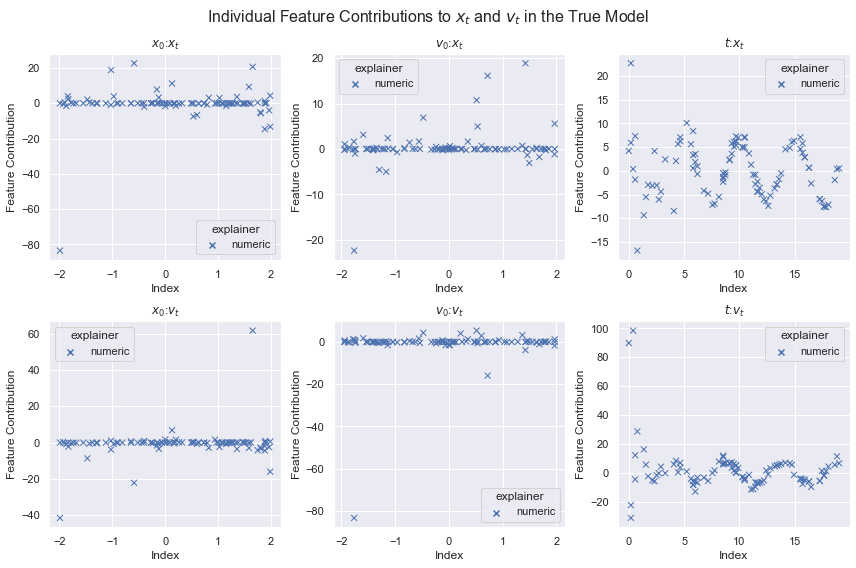

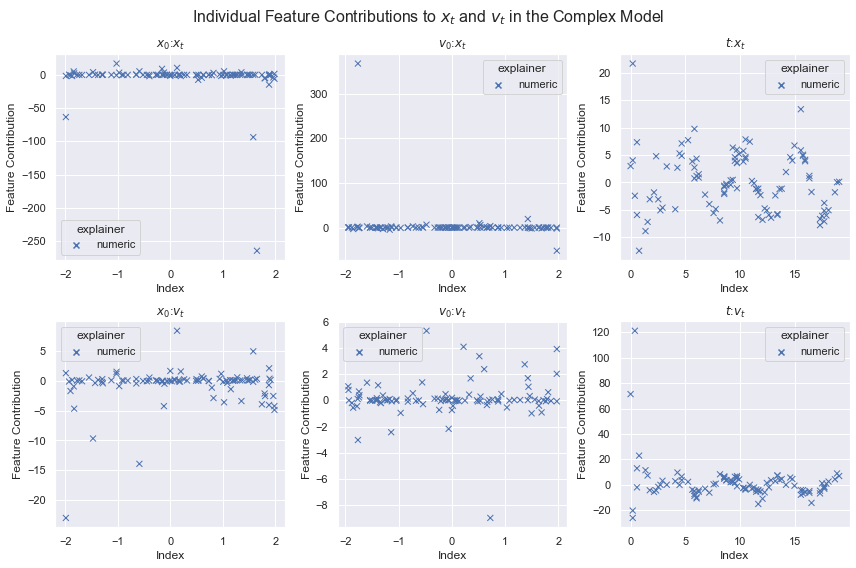

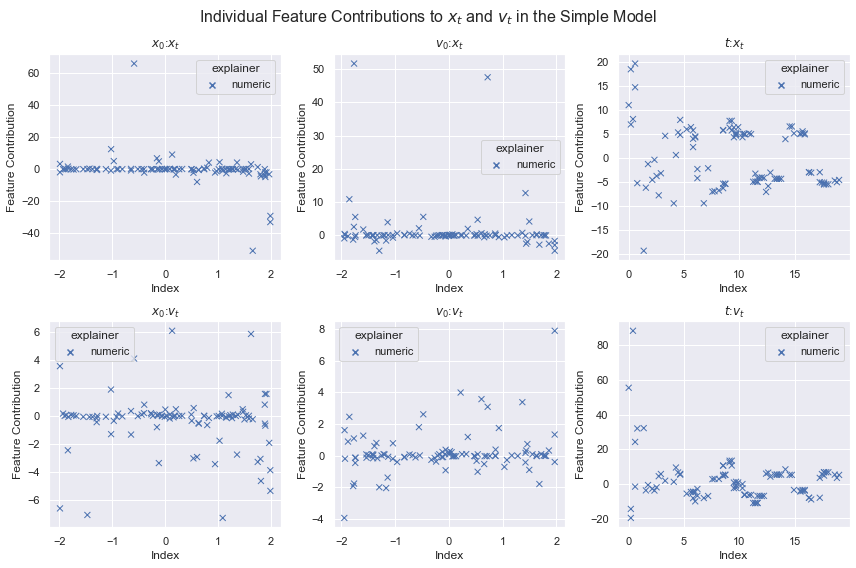

In [16]:
num_limits = [(-0.1,0.1), (-0.1,0.1), (-50,50)]

for models_ in big_df['Model'].unique():
    plotting_df = (big_df.where(big_df["explainer"] == "numeric").where(big_df["Model"] == models_).dropna())
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = 1, hue = "explainer", style = "explainer", edgecolor="none", markers = 'x')
            axs[j,i].set_title(plot_features[i]+":"+plot_labels[j])
            axs[j,i].set_xlabel('Index')
            axs[j,i].set_ylabel('Feature Contribution')
    f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$ in the " + models_ + " Model", fontsize = 16)

    f.tight_layout()
    #if save == True:
     #   f.savefig("Images/Individual/WithLime"+models_+"_"+save_suffix+".svg", dpi='figure')

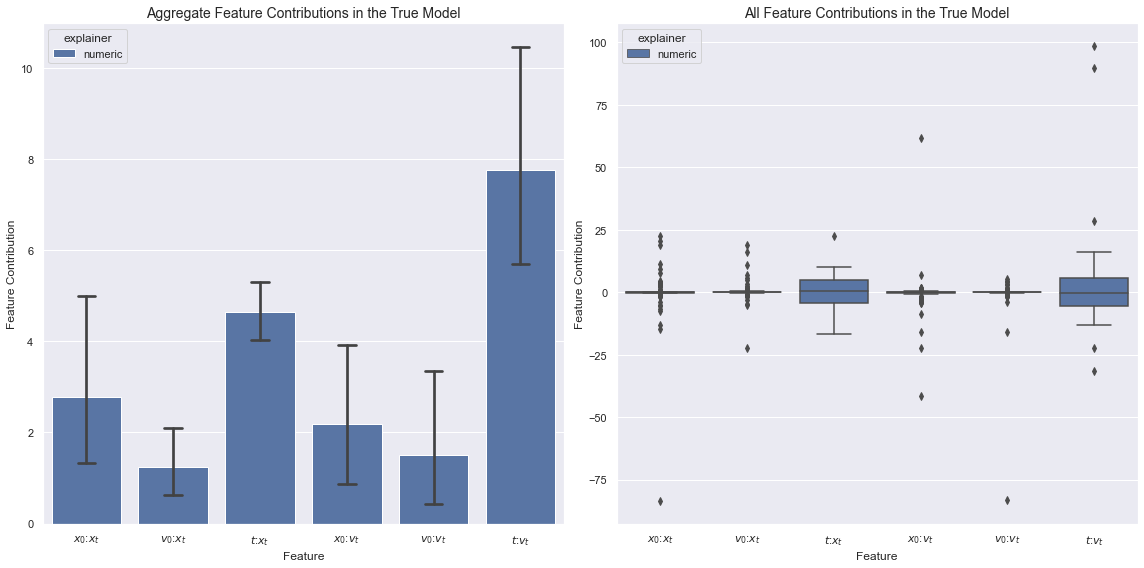

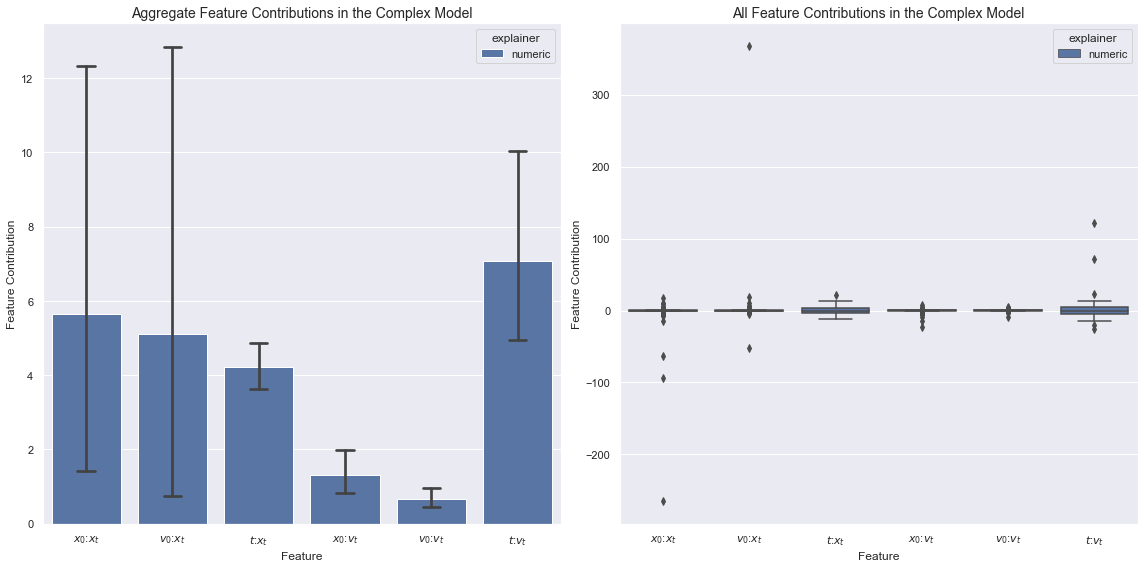

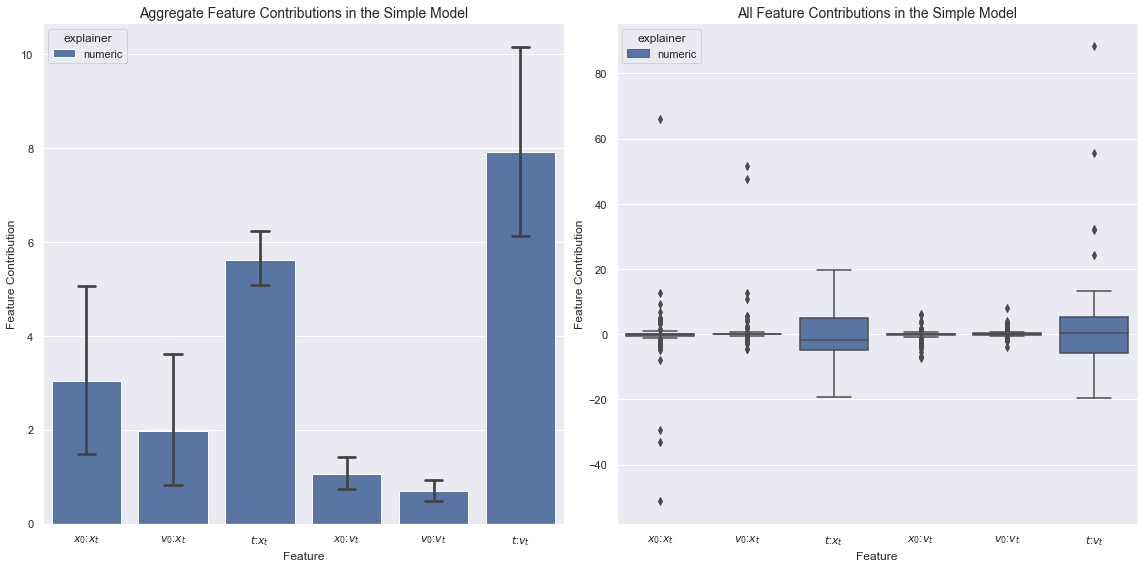

In [14]:
# Convert Data to Long Form to enable plotting with sns barplot
for model_ in Model_types:
    
    plot_cols = [label_+"_"+feat_ for label_ in duffing.labels for feat_ in duffing.features]
    plot_cols.append("explainer")
    model_df = big_df.where(big_df['Model'] == model_).dropna()
    agg_df = model_df[plot_cols].copy().set_index('explainer')
    temp_df = pd.DataFrame()
    agg_df_2 = pd.DataFrame()
    for j, col in enumerate(agg_df.columns[:8]):
        for expl in agg_df.index.unique():
            temp_df['value'] = agg_df.loc[expl][col].values
            temp_df['feature'] = col
            temp_df['explainer'] = expl
            agg_df_2 = agg_df_2.append(temp_df)

    agg_df_3 = agg_df_2.where(agg_df_2["explainer"].isin(["numeric"])).dropna()
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            agg_df_3 = agg_df_3.replace(label_+"_"+feat_, plot_features[i] +":" +plot_labels[j])
            
    # aggregated feature importance

    # Aggregated

    f, axs = plt.subplots(1, 2, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4]))


    sns.barplot(data=agg_df_3, x = 'feature', y = np.abs(agg_df_3['value']), hue = 'explainer', ax = axs[0], ci = 95, capsize=.2)

    axs[0].set_title(r"Aggregate Feature Contributions in the " + model_ + " Model", fontsize = 14)
    axs[0].set_xlabel('Feature')
    axs[0].set_ylabel('Feature Contribution')

    sns.boxplot(data=agg_df_3, x = 'feature', y = 'value', ax = axs[1], hue = 'explainer')
    axs[1].set_title(r"All Feature Contributions in the " + model_ + " Model", fontsize = 14)
    axs[1].set_xlabel('Feature')
    axs[1].set_ylabel('Feature Contribution')


    f.tight_layout()

    if save == True:
        f.savefig("Images/Aggregate/Numeric"+models_+"_"+save_suffix+".svg", dpi='figure')

In [15]:
"""
plot_choice = big_df[duffing.features][:30]
plot_choice_arr = pd.DataFrame()
for time in np.linspace(0, 100, 100, endpoint=False):
    plot_choice["t"] = time
    plot_choice["t"] = duffing.scaler.transform(plot_choice)[:,2]
    plot_choice_arr = plot_choice_arr.append(plot_choice)
    
 # Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt   
  
pred_plot_choice_arr = models["True"].predict(plot_choice_arr)


time = range(100)

def f1(time = 0, num_samples = 1000):
    return pred_plot_choice_arr[time*30:(time+1)*30,0]
    
def f2(rand, time = 0):
    return pred_plot_choice_arr[time*30:(time+1)*30,1]


fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time)
plt.show()


ax.set_title(r"Evolution of Datapoints in Phase Space")
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$v_t$")

def numeric_norm(dataframe):
    data_copy = dataframe.copy()
    X = dataframe[duffing.features]
    scaled_df = pd.DataFrame(duffing.scaler.inverse_transform(X), columns = duffing.features)
    y = pd.DataFrame(models["True"].predict(X), columns = duffing.labels)
    for i in duffing.labels:
        y_vals = y[i]
        y_mean = y[i].mean()
        Omega = np.zeros_like(y_vals)
        
        for j in duffing.features:
            Omega += np.array(dataframe[i+"_"+j]) * np.array(scaled_df[j])
            
        for j in duffing.features:
            data_copy[i+"_"+j] = np.array(dataframe[i+"_"+j]) * np.array(y_vals) / Omega
        
    return data_copy
    
def scale_numeric(dataframe):
    data_out = dataframe.copy()
    max_val = np.max(big_df.where(big_df["explainer"] != "numeric").dropna().loc[:,"xt_x0":"vt_t"].max())
    scaler = MinMaxScaler((-max_val, max_val))
    data_out.loc[:,"xt_x0":"vt_t"]=scaler.fit_transform(dataframe.loc[:,"xt_x0":"vt_t"])
    return data_out 
    
background = shap.sample(duffing.X_df[duffing.features], 100)

temp_explainer = shap.KernelExplainer(models["Simple"], background)
temp_vals = temp_explainer.shap_values(pd.DataFrame(duffing.scaler.transform(X[:100])), columns = duffing.features)

plotting_df = duffing.vals_to_df(temp_vals, X[:100])
plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                             columns = features)
f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                  gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
for i, feat_ in enumerate(duffing.features):
    for j, label_ in enumerate(duffing.labels):
        sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                        linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none")
        axs[j,i].set_title(plot_features[i]+":"+plot_labels[j])
        axs[j,i].set_xlabel('Index')
        axs[j,i].set_ylabel('Feature Contribution')
f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$ in the " + models_ + " Model", fontsize = 16)

f.tight_layout()
"""

'\nplot_choice = big_df[duffing.features][:30]\nplot_choice_arr = pd.DataFrame()\nfor time in np.linspace(0, 100, 100, endpoint=False):\n    plot_choice["t"] = time\n    plot_choice["t"] = duffing.scaler.transform(plot_choice)[:,2]\n    plot_choice_arr = plot_choice_arr.append(plot_choice)\n    \n # Enable Jupyter Notebook\'s intellisense\n%config IPCompleter.greedy=True\n%matplotlib inline\n\n%matplotlib notebook\nfrom ipywidgets import *\nimport numpy as np\nimport matplotlib.pyplot as plt   \n  \npred_plot_choice_arr = models["True"].predict(plot_choice_arr)\n\n\ntime = range(100)\n\ndef f1(time = 0, num_samples = 1000):\n    return pred_plot_choice_arr[time*30:(time+1)*30,0]\n    \ndef f2(rand, time = 0):\n    return pred_plot_choice_arr[time*30:(time+1)*30,1]\n\n\nfig, ax = plt.subplots()\ncontrols = iplt.plot(f1, f2, \'x\', time=time)\nplt.show()\n\n\nax.set_title(r"Evolution of Datapoints in Phase Space")\nax.set_xlabel(r"$x_t$")\nax.set_ylabel(r"$v_t$")\n\ndef numeric_norm(data